In [37]:
%pip install Wordcloud
%pip install Sastrawi
%pip install seaborn
%pip install imblearn
%pip install kaggle


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
!kaggle datasets list -s analisis-sentimen

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
pajarbebek/analisis-sentimen-timnas-sepakbola-di-era-sty         Analisis Sentimen Timnas Sepakbola di Era STY        27KB  2024-01-12 07:55:23            447         10  0.88235295       
ucupsedaya/gojek-app-reviews-bahasa-indonesia                    Gojek🏍 App Reviews Bahasa Indonesia                   8MB  2024-02-03 11:21:41            756         18  1.0              
dewanakretarta/gojek-playstore-reviews                           Gojek Playstore Reviews                              56MB  2024-08-29 15:43:51            229          8  1.0              
dewanakretarta/whatsapp-playstore-review               

In [40]:
!kaggle datasets download billycemerson/analisis-sentimen-terkait-intensif-mobil-listrik

Dataset URL: https://www.kaggle.com/datasets/billycemerson/analisis-sentimen-terkait-intensif-mobil-listrik
License(s): unknown
analisis-sentimen-terkait-intensif-mobil-listrik.zip: Skipping, found more recently modified local copy (use --force to force download)


In [41]:
import zipfile

# Tentukan path file zip dan folder tujuan ekstraksi
zip_file_path = 'analisis-sentimen-terkait-intensif-mobil-listrik.zip'
extract_path = './extracted_files'

# Ekstraksi file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File zip berhasil diekstrak ke folder:", extract_path)


File zip berhasil diekstrak ke folder: ./extracted_files


In [42]:
data = pd.read_csv('./extracted_files/mobil_listrik.csv')
data.head()

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen
0,Ugzbll5eyrIy3-gdUUJ4AaABAg,Sqn Ldr,2023-08-06 12:54:49+00:00,saran sih bikin harga ionic sama kayak brio ...,positif
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif


## 1. Data Understanding

In [43]:
data.dtypes

id_komentar      object
nama_akun        object
tanggal          object
text_cleaning    object
sentimen         object
dtype: object

In [44]:
data.shape

(1517, 5)

In [45]:
data = data.dropna()
data.isnull().sum()

id_komentar      0
nama_akun        0
tanggal          0
text_cleaning    0
sentimen         0
dtype: int64

In [46]:
data = data.drop_duplicates()
data.duplicated().sum()

np.int64(0)

In [47]:
data.describe()

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen
count,1514,1514,1514,1514,1514
unique,1514,1513,1511,1513,3
top,UgyUFUCTdK_RJFsYwQV4AaABAg,Albert,2023-06-06 15:19:27+00:00,mahal,negatif
freq,1,2,2,2,868


## 2. Preprocessing Text

In [48]:
data.head()

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen
0,Ugzbll5eyrIy3-gdUUJ4AaABAg,Sqn Ldr,2023-08-06 12:54:49+00:00,saran sih bikin harga ionic sama kayak brio ...,positif
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif


In [49]:
data = data.drop(columns=['id_komentar','nama_akun','tanggal'])
data.head()

,text_cleaning,sentimen
0,saran sih bikin harga ionic sama kayak brio ...,positif
1,problem subsidi kualitas diturunin harga dinai...,negatif
2,baik kualitas kembang dulu baik kualitas motor...,positif
3,model jelek kwalitas buruk harga mahal croot,negatif
4,syarat ngaco woy anak muda blom punya ruma...,negatif


In [50]:
# Mengubah data menjadi lowercase
data['text_cleaning'] = data['text_cleaning'].str.lower()
data.head()

,text_cleaning,sentimen
0,saran sih bikin harga ionic sama kayak brio ...,positif
1,problem subsidi kualitas diturunin harga dinai...,negatif
2,baik kualitas kembang dulu baik kualitas motor...,positif
3,model jelek kwalitas buruk harga mahal croot,negatif
4,syarat ngaco woy anak muda blom punya ruma...,negatif


In [51]:
# Normalisasi
norm = {"problem" : "masalah", "kwalitas" : "kualitas", "ngaco" : "sembarangan", "aing" : "aku", "tehnologi" : "teknologi", "msh" : "masih", "dl" : "dulu", "donk" : "dong", "kpd" : "kepada", "dg" : "dengan", "jk" : "jika", "kudu" : "harus", "plg" : "paling", "blom" : "belum", "jd" : "jadi", "dg" : "dengan", "iru" : "itu", "duid" : "duit", "bgsd" : "bangsat", "jt" : "juta", "negri" : "negeri", "jln" : "jalan", "hny" : "hanya", "dn" : "dan", "esemka" : "SMK", "brg" : "barang", "batre" : "baterai", "batere" : "baterai", "ujan" : "hujan", "sblm" : "sebelum"}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

data['text_cleaning'] = data['text_cleaning'].apply(lambda x: normalisasi(x))

In [52]:
# Stopword
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_word = []

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

data['text_cleaning'] = data['text_cleaning'].apply(lambda x: stopword(x))
data.head()

,text_cleaning,sentimen
0,saran sih bikin harga ionic sama kayak brio ...,positif
1,masalah subsidi kualitas diturunin harga dinai...,negatif
2,baik kualitas kembang dulu baik kualitas motor...,positif
3,model jelek kualitas buruk harga mahal croot,negatif
4,syarat sembarangan woy anak muda punya rum...,negatif


In [53]:
# Tokenize
tokenized = data['text_cleaning'].apply(lambda x:x.split())
tokenized

0       [saran, sih, bikin, harga, ionic, sama, kayak,...
1       [masalah, subsidi, kualitas, diturunin, harga,...
2       [baik, kualitas, kembang, dulu, baik, kualitas...
3       [model, jelek, kualitas, buruk, harga, mahal, ...
4       [syarat, sembarangan, woy, anak, muda, punya, ...
                              ...                        
1512    [apa, kabar, padahal, negeri, luar, biasa, neg...
1513    [antar, anak, sekolah, antar, bantu, pasar, kl...
1514                                  [SMK, bangga, solo]
1515    [cerdas, orang, dan, pasar, jalan, x, da, gima...
1516    [niat, beli, ev, murah, malah, ikut, dinaikin,...
Name: text_cleaning, Length: 1514, dtype: object

In [56]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)

pathlib.Path('./dataset_bersih').mkdir(parents=True, exist_ok=True)

tokenized.to_csv('./dataset_bersih/mobil_listrik_bersih.csv', index=False)
data_clean = pd.read_csv('./dataset_bersih/mobil_listrik_bersih.csv', encoding='latin1')

saran sih bikin harga ionic sama kayak brio insya alloh laris manis
masalah subsidi kualitas diturunin harga dinaikin usaha gitu cari cuan subsidi inflasi paling gede
baik kualitas kembang dulu baik kualitas motor motor pabrikan jepang
model jelek kualitas buruk harga mahal croot
syarat sembarang woy anak muda punya rumah jadi umkm bukan kur dapet sembarang sia deui sia deui nu narima subsidi teh ari aku iraha
harga motor mahal masa harga mirip motor beat kualitas bagai langit bumi
mol keren yah berita plus padahal mol lokal merk baterai juta garansi tahun anggap baterai awet tahun rakyat indonesia per tahun sekali keluar juta buat beli baterai baru o saran uang subsidi keluar buat baterai perintah punya wewenang pertamina kelola contoh gas kg gas kg gas kg produk baru misal baterai v baterai v baterai v cabut bayar pasang gas pnp pom sistem swap baterai banyak titik swap point indonesia luas
proses kenal produk baru butuh waktu ganti kendara bbm jadi kendara butuh waktu teknologi baru

In [57]:
data_clean.head()

,text_cleaning
0,saran sih bikin harga ionic sama kayak brio in...
1,masalah subsidi kualitas diturunin harga dinai...
2,baik kualitas kembang dulu baik kualitas motor...
3,model jelek kualitas buruk harga mahal croot
4,syarat sembarang woy anak muda punya rumah jad...


In [62]:
atribut1 = pd.read_csv('dataset_bersih/mobil_listrik_bersih.csv')
atribut2 = pd.read_csv('extracted_files/mobil_listrik.csv')
merge_atribut = atribut2['sentimen']

data_clean = pd.concat([atribut1, merge_atribut], axis=1)
data_clean

,text_cleaning,sentimen
0,saran sih bikin harga ionic sama kayak brio in...,positif
1,masalah subsidi kualitas diturunin harga dinai...,negatif
2,baik kualitas kembang dulu baik kualitas motor...,positif
3,model jelek kualitas buruk harga mahal croot,negatif
4,syarat sembarang woy anak muda punya rumah jad...,negatif
...,...,...
1512,cerdas orang dan pasar jalan x da gimana kota ...,negatif
1513,niat beli ev murah malah ikut dinaikin sama pe...,negatif
1514,NaN,positif
1515,NaN,netral


In [63]:
# Menghapus nilai NaN
data_clean = data_clean.dropna()
data_clean

,text_cleaning,sentimen
0,saran sih bikin harga ionic sama kayak brio in...,positif
1,masalah subsidi kualitas diturunin harga dinai...,negatif
2,baik kualitas kembang dulu baik kualitas motor...,positif
3,model jelek kualitas buruk harga mahal croot,negatif
4,syarat sembarang woy anak muda punya rumah jad...,negatif
...,...,...
1509,apa kabar padahal negeri luar biasa negara,negatif
1510,antar anak sekolah antar bantu pasar klw jauh ...,positif
1511,smk bangga solo,positif
1512,cerdas orang dan pasar jalan x da gimana kota ...,negatif


## 3. Visualisasi Kata

In [64]:
data_negatif = data_clean[data_clean['sentimen'] == 'negatif']
data_positif = data_clean[data_clean['sentimen'] == 'positif']
data_netral = data_clean[data_clean['sentimen'] == 'netral']

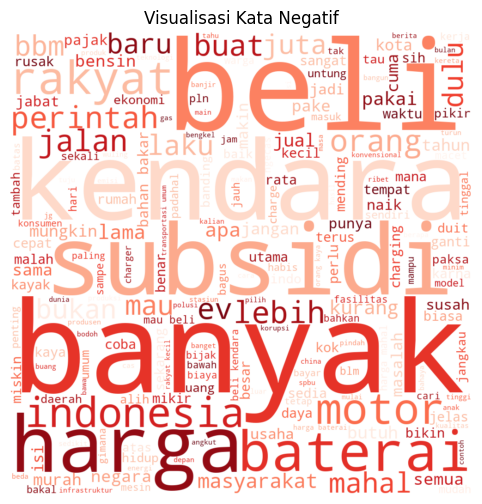

In [65]:
all_text_negatif = ' '.join(word for word in data_negatif["text_cleaning"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_negatif)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Negatif")
plt.margins(x=0, y=0)
plt.show()

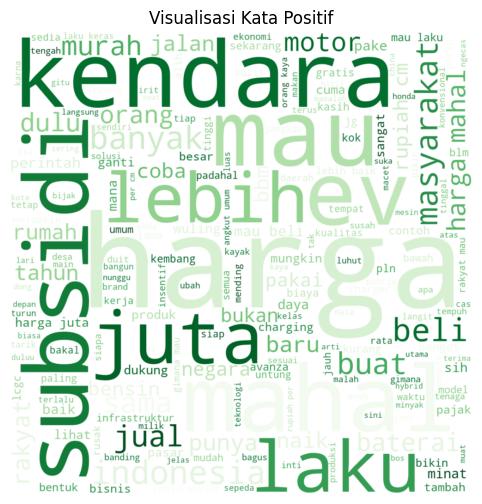

In [66]:
all_text_positif = ' '.join(word for word in data_positif["text_cleaning"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_positif)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Positif")
plt.margins(x=0, y=0)
plt.show()

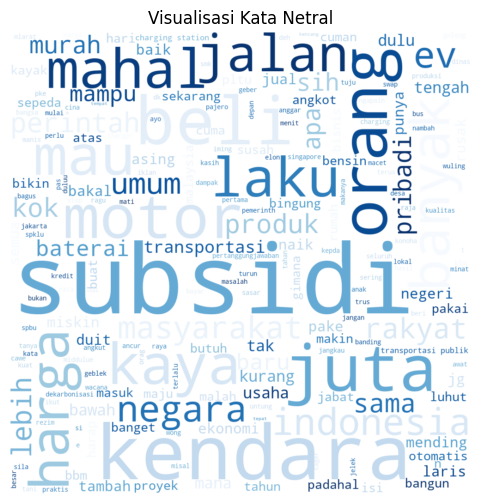

In [67]:
all_text_netral = ' '.join(word for word in data_netral["text_cleaning"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_netral)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Netral")
plt.margins(x=0, y=0)
plt.show()

In [68]:
data_clean['sentimen'].value_counts()

sentimen
negatif    868
positif    503
netral     143
Name: count, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_17392\477826870.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_clean, x='sentimen', palette={'negatif': "lightcoral", 'positif': "lightgreen", 'netral': "lightskyblue"})


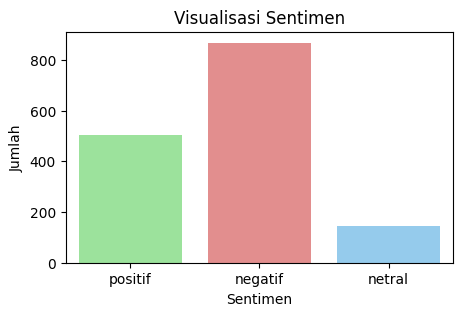

In [69]:
# Visualisasi Sentimen
plt.figure(figsize=(5, 3))
sns.countplot(data=data_clean, x='sentimen', palette={'negatif': "lightcoral", 'positif': "lightgreen", 'netral': "lightskyblue"})
plt.title("Visualisasi Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

## 4. Data Preparation

In [70]:
# Split data training dan testing
x = data_clean['text_cleaning']
y = data_clean['sentimen']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [71]:
# Mengubah text menjadi fitur numerik
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [72]:
# Oversampling menggunakan SMOTE pada data train
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_vec, y_train)

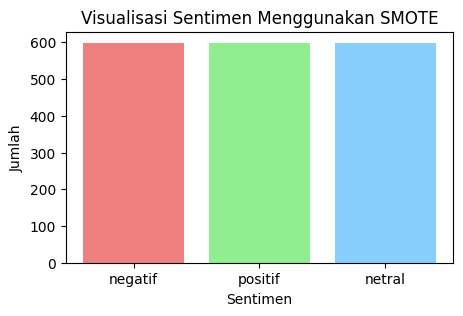

In [73]:
sentimen_counts = y_train_resampled.value_counts()

plt.figure(figsize=(5, 3))
plt.bar(sentimen_counts.index, sentimen_counts.values, color=['lightcoral', 'lightgreen', 'lightskyblue'])
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.title("Visualisasi Sentimen Menggunakan SMOTE")
plt.xticks(sentimen_counts.index, ['negatif', 'positif', 'netral'])
plt.show()

## 5. Modeling

In [74]:
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train_resampled, y_train_resampled)

MultinomialNB()

In [75]:
y_pred = naive_bayes.predict(x_test_vec)

In [76]:
# Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred, target_names=['negatif', 'positif', 'netral'])

print("Akurasi Model Naive Bayes: ", accuracy)
print("\nLaporan Klasifikasi: \n", classification)

Akurasi Model Naive Bayes:  0.6835164835164835

Laporan Klasifikasi: 
               precision    recall  f1-score   support

     negatif       0.73      0.85      0.79       269
     positif       0.25      0.17      0.20        41
      netral       0.66      0.52      0.58       145

    accuracy                           0.68       455
   macro avg       0.55      0.51      0.52       455
weighted avg       0.67      0.68      0.67       455



## 6. Testing

In [85]:
import time
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Load dataset yang sudah dibersihkan
data_clean = pd.read_csv('./dataset_bersih/mobil_listrik_bersih.csv')
labels = pd.read_csv('./extracted_files/mobil_listrik.csv')['sentimen']

# Sinkronisasi panjang data_clean dan labels
if len(data_clean) != len(labels):
    min_length = min(len(data_clean), len(labels))
    data_clean = data_clean.iloc[:min_length]
    labels = labels[:min_length]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_clean, labels, test_size=0.3, random_state=42)

# Vectorization
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['text_cleaning'])
X_test_vec = vectorizer.transform(X_test['text_cleaning'])

# Melatih model
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec, y_train)

def clear_screen():
    os.system('cls' if os.name == 'nt' else 'clear')

def print_slow(text):
    for char in text:
        print(char, end='', flush=True)
        time.sleep(0.02)
    print()

def print_banner():
    print("\n" + "=" * 60)
    print_slow("🚗⚡ Selamat Datang di Program Restrik 🔋🔍")
    print_slow("Sentiment Analysis: Review Mobil Listrik")
    print("=" * 60)

def get_emoji(sentiment):
    return {
        "positif": "😃",
        "netral": "😐",
        "negatif": "😞"
    }.get(sentiment, "❓")

def analyze_sentiment(review):
    review_vec = vectorizer.transform([review])
    predicted_sentiment = naive_bayes.predict(review_vec)[0]
    return predicted_sentiment

def main():
    while True:
        clear_screen()
        print_banner()
        
        print("\nSilakan masukkan review Anda tentang mobil listrik.")
        print("Ketik 'keluar' untuk mengakhiri program.")
        
        review = input("\n📝 Review Anda: ")
        
        if review.lower() == 'keluar':
            print_slow("\nTerima kasih telah menggunakan program Restrik!")
            print("=" * 60)
            break
        
        print("\nMenganalisis sentimen...")
        for _ in range(3):
            print(".", end='', flush=True)
            time.sleep(0.5)
        print("\n")
        
        sentiment = analyze_sentiment(review)
        emoji = get_emoji(sentiment)
        
        print("-" * 60)
        print(f"📊 Hasil Analisis Sentimen")
        print("-" * 60)
        print(f"Review  : {review}")
        print(f"Sentimen: {sentiment.capitalize()} {emoji}")
        print("-" * 60)
        
        if sentiment == "positif":
            print_slow("Wow! Sepertinya Anda sangat menyukai mobil listrik ini!")
        elif sentiment == "netral":
            print_slow("Hmm, Anda memiliki pandangan yang cukup netral tentang mobil ini.")
        else:
            print_slow("Oh, maaf mendengar Anda kurang puas dengan mobil listrik ini.")
        
        input("\nTekan Enter untuk melanjutkan...")

if __name__ == "__main__":
    main()



🚗⚡ Selamat Datang di Program Restrik 🔋🔍
Sentiment Analysis: Review Mobil Listrik

Silakan masukkan review Anda tentang mobil listrik.
Ketik 'keluar' untuk mengakhiri program.

Menganalisis sentimen...
...

------------------------------------------------------------
📊 Hasil Analisis Sentimen
------------------------------------------------------------
Review  : Teknologi yang sangat inovatif
Sentimen: Positif 😃
------------------------------------------------------------
Wow! Sepertinya Anda sangat menyukai mobil listrik ini!

🚗⚡ Selamat Datang di Program Restrik 🔋🔍
Sentiment Analysis: Review Mobil Listrik

Silakan masukkan review Anda tentang mobil listrik.
Ketik 'keluar' untuk mengakhiri program.

Menganalisis sentimen...
...

------------------------------------------------------------
📊 Hasil Analisis Sentimen
------------------------------------------------------------
Review  : saya kurang suka modelnya
Sentimen: Negatif 😞
--------------------------------------------------------

In [79]:
# new_comment = input("\nMasukkan komentar: ")
# new_comment_vec = vectorizer.transform([new_comment])
# predicted_sentimen = naive_bayes.predict(new_comment_vec)

# sentiment_label = predicted_sentimen[0]

# print(f"Komentar: {new_comment}")
# print(f"Sentimen dari komentar: {sentiment_label}")

Komentar: Teknologi yang sangat inovatif
Sentimen dari komentar: positif
